# ML_25M Classic ML

In [11]:
import os
import copy
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from torch.utils.tensorboard import SummaryWriter

seed = 42
np.random.seed(seed)
random.seed(seed)
df = pd.read_csv('dataset.csv')

if os.path.exists('classicML'):
    os.system('rm -r classicML')

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


## Data Preprocessing

In [3]:
X = df.drop('rating', axis=1)
Y = df['rating']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [119]:
# PCA
pca = PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [120]:
print(f'Number of training samples: {X_train.shape}')
print(f'Number of testing samples: {X_test.shape}')

Number of training samples: (11052, 1128)
Number of testing samples: (2764, 1128)


# Models

## Random Forest Regressor

In [121]:
# hyperparameter tuning
n_tree = [ i for i in range(50, 100, 5)]
criterion = ["squared_error", "friedman_mse", "poisson"]

rfr_best_mse = float('inf')
rfr_best_n = None
rfr_best_c = None
rfr_best = None

i = 0
max_iter = len(n_tree) * len(criterion)

history_rfr = []

for n, c in itertools.product(n_tree, criterion):
    i += 1
    log_name = f"n_estimators={n}, criterion={c}"
    writer = SummaryWriter(f"classicML/RFR/{log_name}")

    rf = RandomForestRegressor(n_estimators=n, criterion=c)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)
    mse = np.mean((Y_pred - Y_test)**2)

    history_rfr.append([n, c, mse])

    writer.add_scalar('Loss', mse, n)
    writer.add_hparams(
        {'n_estimators': n, 'criterion': c},
        {'mse': mse}
    )
    writer.flush()

    if mse < rfr_best_mse:
        rfr_best_mse = mse
        rfr_best_n = n
        rfr_best_c = c
        rfr_best = copy.deepcopy(rf)
    
    print(" Iteration: {}/{} - N_estimator: {} - Criterion: {} - MSE: {:.4f} - Best MSE: {:.4f}".format(i, max_iter, n, c, mse, rfr_best_mse), end='\r')

Y_pred = rfr_best.predict(X_test)
rf_r2 = r2_score(Y_test, Y_pred)

print("\nRFR Hyperparameter Tuning Results")
print(" - N estimators: ", rfr_best_n)
print(" - Criterion: ", rfr_best_c)
print(" - MSE: ", rfr_best_mse)
print(" - R2: ", rf_r2)

 Iteration: 9/9 - N_estimator: 7 - Criterion: poisson - MSE: 0.0147 - Best MSE: 0.0147.01556
RFR Hyperparameter Tuning Results
 - N estimators:  7
 - Criterion:  poisson
 - MSE:  0.014700545743017365
 - R2:  0.9336815771224942


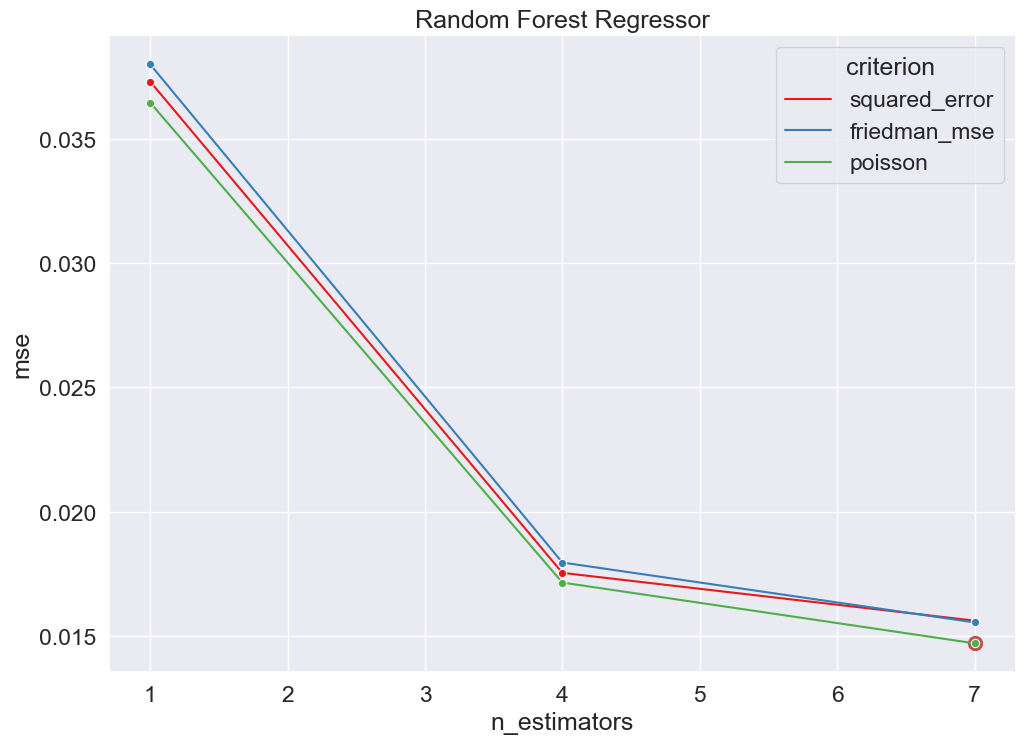

In [127]:
# plot results with sns 
history_rfr = pd.DataFrame(history_rfr, columns=['n_estimators', 'criterion', 'mse'])
sns.lineplot(x='n_estimators', y='mse', hue='criterion', data=history_rfr, palette='Set1', marker='o')
plt.title('Random Forest Regressor')
plt.scatter(rfr_best_n, rfr_best_mse, marker='o', color='r', s=100)
plt.show()


## Support Vector Regressor

In [8]:
# support vector regression tuning
c = [0.001, 0.01, 0.1, 1]
epsilon = [0.001, 0.01, 0.1, 1]
kernel = ['linear', 'poly', 'rbf']

svr_best_mse = float('inf')
svr_best_c = None
svr_best_epsilon = None
svr_best_kernel = None
svr_best = None

i = 0
max_iter = len(c) * len(epsilon) * len(kernel)

history_svr = []

for c_, epsilon_, kernel_ in itertools.product(c, epsilon, kernel):
    i += 1
    log_name = f"c={c_}, epsilon={epsilon_}, kernel={kernel_}"
    writer = SummaryWriter(f"classicML/SVR/{log_name}")

    svr = SVR(C=c_, epsilon=epsilon_, kernel=kernel_)
    svr.fit(X_train, Y_train)
    Y_pred = svr.predict(X_test)
    mse = np.mean((Y_pred - Y_test)**2)

    writer.add_hparams(
        {'c': c_, 'epsilon': epsilon_, 'kernel': kernel_},
        {'mse': mse}
    )
    writer.flush()

    history_svr.append([c_, epsilon_, kernel_, mse])

    if mse < svr_best_mse:
        svr_best_mse = mse
        svr_best_c = c_
        svr_best_epsilon = epsilon_
        svr_best_kernel = kernel_
        svr_best = copy.deepcopy(svr)
    
    print(" Iteration: {}/{} - C: {} - Epsilon: {} -  Kernel: {} - MSE: {:.4f} - Best MSE: {:.4f}".format(i, max_iter, c_, epsilon_, kernel_, mse, svr_best_mse), end='\r')

Y_pred = svr_best.predict(X_test)
svr_r2 = r2_score(Y_test, Y_pred)

print("\nSVR Hyperparameter Tuning Results")
print(" - C: ", svr_best_c)
print(" - Epsilon: ", svr_best_epsilon)
print(" - Kernel: ", svr_best_kernel)
print(" - MSE: ", svr_best_mse)
print(" - R2: ", svr_r2)

KeyboardInterrupt: 

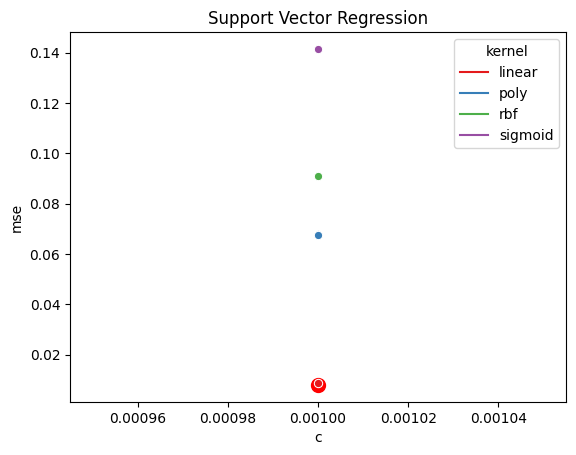

In [10]:
history_svr = pd.DataFrame(history_svr, columns=['c', 'epsilon', 'kernel', 'mse'])
sns.lineplot(x='c', y='mse', hue='kernel', data=history_svr, palette='Set1', marker='o')
plt.title('Support Vector Regression')
plt.scatter(svr_best_c, svr_best_mse, marker='o', color='r', s=100)
plt.show()

## Linear Regressor

In [39]:
log_name = f"linear_regression"
writer = SummaryWriter(f"classicML/LinearR/{log_name}")

lr = LinearRegression()
lr.fit(X_train, Y_train)
Y_pred = lr.predict(X_test)
mse = np.mean((Y_pred - Y_test)**2)

writer.add_scalar('Loss', mse)
writer.flush()

Y_pred = lr.predict(X_test)
lr_r2 = r2_score(Y_test, Y_pred)

print("Linear Regression Results")
print(" - MSE: ", mse)
print(" - R2: ", lr_r2)


Linear Regression Results
 - MSE:  0.005388314172313805
 - R2:  0.975691752937397


## Ridge Regression

In [108]:
# ridge regression
from sklearn.linear_model import Ridge

alpha = [0.0001, 0.001, 0.1, 0.5, 1, 5, 10, 20]

rr_best_mse = float('inf')
rr_best_a = None
rr_best = None

history_rr = []

i = 0
max_iter = len(alpha)

for a in alpha:
    i += 1
    log_name = f"alpha={a}"
    writer = SummaryWriter(f"classicML/RidgeR/{log_name}")

    rr = Ridge(alpha=a)
    rr.fit(X_train, Y_train)
    Y_pred = rr.predict(X_test)
    mse = np.mean((Y_pred - Y_test)**2)

    writer.add_scalar('Loss', mse, a)
    writer.add_hparams(
        {'alpha': a},
        {'mse': mse}
    )
    
    writer.flush()

    history_rr.append((a,mse))

    if mse < rr_best_mse:
        rr_best_mse = mse
        rr_best_a = a
        rr_best = copy.deepcopy(rr)

    print("Iteration: {}/{} - Alpha: {} - MSE: {:.4f} - Best MSE: {:.4f}".format(i, max_iter, a, mse, rr_best_mse), end='\r')

Y_pred = rr_best.predict(X_test)
rr_r2 = r2_score(Y_test, Y_pred)

print("\nRidge Regression Hyperparameter Tuning Results")
print(" - Alpha: ", rr_best_a)
print(" - MSE: ", rr_best_mse)
print(" - R2: ", rr_r2)

Iteration: 8/8 - Alpha: 20 - MSE: 0.0056 - Best MSE: 0.00533544
Ridge Regression Hyperparameter Tuning Results
 - Alpha:  5
 - MSE:  0.0052764030790176065
 - R2:  0.9761966163172769


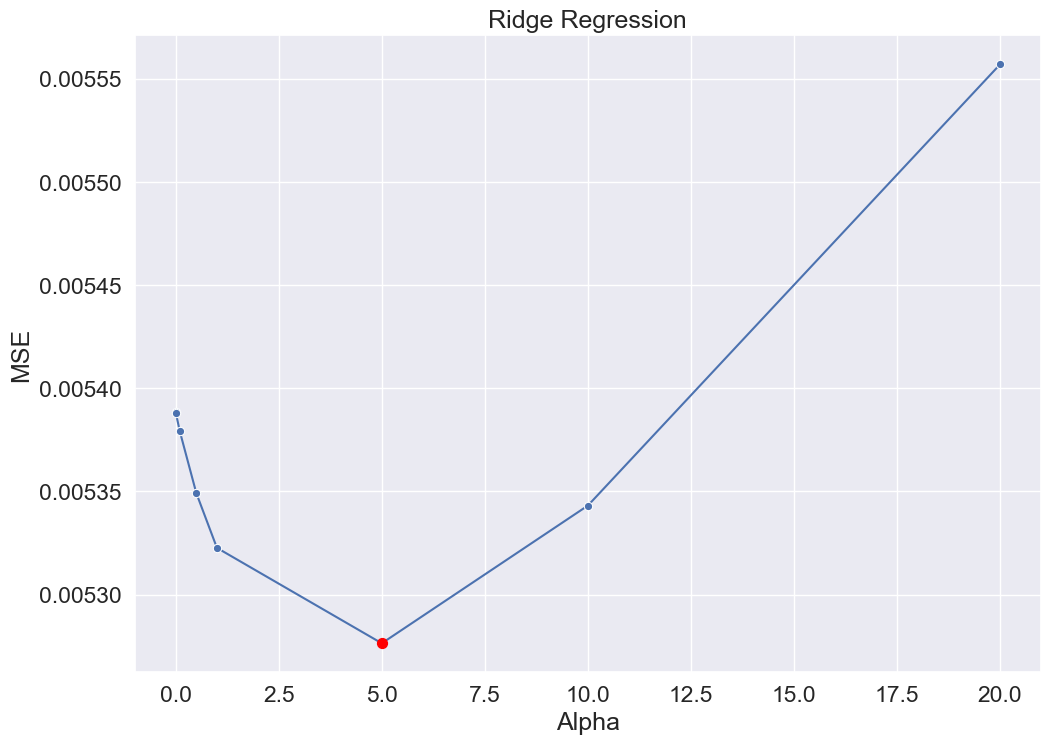

In [113]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize': (11.7, 8.27)})
sns.set(font_scale=1.5)

history_rr = np.array(history_rr)

ax = sns.lineplot(x=history_rr[:, 0], y=history_rr[:, 1], marker='o')

ax.set(xlabel='Alpha', ylabel='MSE')
ax.set_title('Ridge Regression')
ax.scatter(rr_best_a, rr_best_mse, color='red', s=50, marker='o', zorder=3)
plt.show()

## Lasso Regressor

In [ ]:
# lasso regression
from sklearn.linear_model import Lasso

alpha = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]

lasso_best_mse = float('inf')
lasso_best_a = None
lasso_best = None

i = 0
max_iter = len(alpha)

history_lasso = []

for a in alpha:
    i += 1
    log_name = f"alpha={a}"
    writer = SummaryWriter(f"classicML/LassoR/{log_name}")

    lasso = Lasso(alpha=a)
    lasso.fit(X_train, Y_train)
    Y_pred = lasso.predict(X_test)
    mse = np.mean((Y_pred - Y_test)**2)

    history_lasso.append((a,mse))

    writer.add_scalar('Loss', mse, a)
    writer.add_hparams(
        {'alpha': a},
        {'mse': mse}
    )

    if mse < lasso_best_mse:
        lasso_best_mse = mse
        lasso_best_a = a
        lasso_best = copy.deepcopy(lasso)

    print("Iteration: {}/{} - Alpha: {} - MSE: {:.4f} - Best MSE: {:.4f}".format(i, max_iter, a, mse, best_mse), end='\r')

Y_pred = lasso_best.predict(X_test)
lasso_r2 = r2_score(Y_test, Y_pred)

print("\nLasso Regression Hyperparameter Tuning Results")
print(" - Alpha: ", lasso_best_a)
print(" - MSE: ", lasso_best_mse)
print(" - R2: ", lasso_r2)

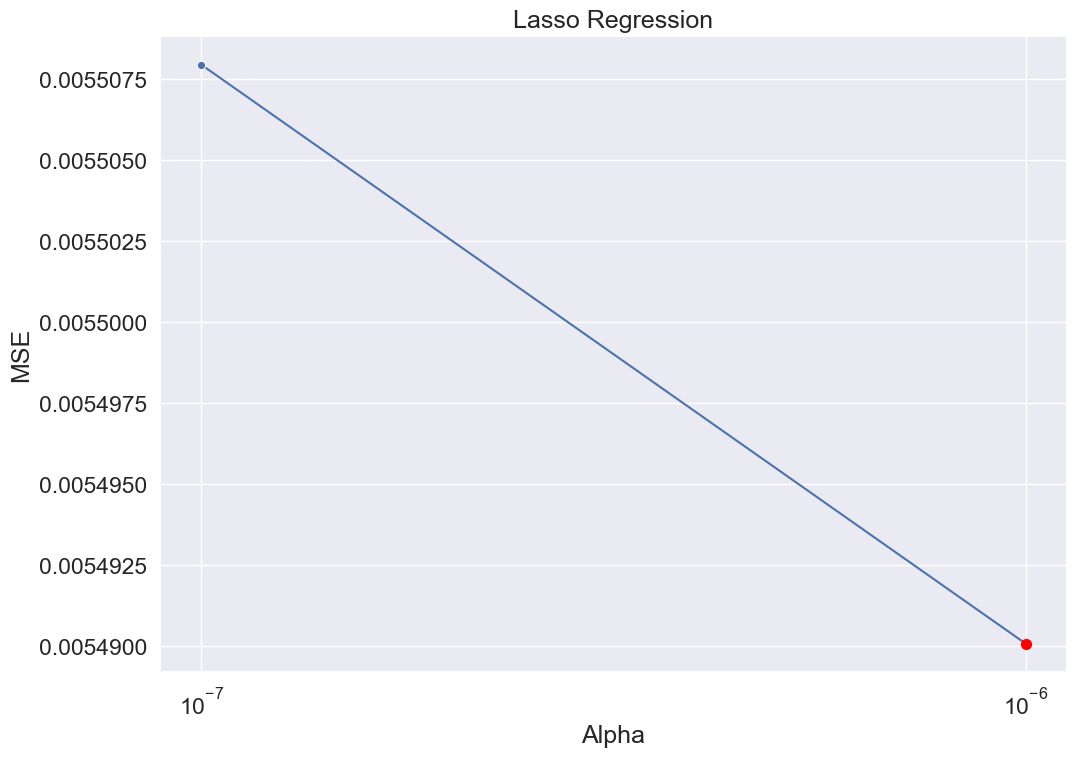

In [118]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)

history_lasso = np.array(history_lasso)

ax = sns.lineplot(x=history_lasso[:,0], y=history_lasso[:,1], marker='o')
ax.set(xscale="log")
ax.set(xlabel='Alpha', ylabel='MSE')
ax.set_title('Lasso Regression')
ax.scatter(lasso_best_a, lasso_best_mse, color='red', s=50, marker='o', zorder=3)
plt.show()

## Elastic Net

In [103]:
# elastic net
from sklearn.linear_model import ElasticNet

alpha = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5,]

elastic_best_mse = float('inf')
elastic_best_a = None
elastic_best = None

i = 0
max_iter = len(alpha)

history_elastic = []

for a in alpha:
    i += 1
    log_name = f"alpha={a}"
    writer = SummaryWriter(f"classicML/ElasticNetR/{log_name}")

    elastic = ElasticNet(alpha=a)
    elastic.fit(X_train, Y_train)
    Y_pred = elastic.predict(X_test)
    mse = np.mean((Y_pred - Y_test)**2)

    writer.add_scalar('Loss', mse, a)
    writer.add_hparams(
        {'alpha': a},
        {'mse': mse}
    )

    history_elastic.append((a,mse))

    if mse < elastic_best_mse:
        elastic_best_mse = mse
        elastic_best_a = a
        elastic_best = copy.deepcopy(elastic)

    print("Iteration: {}/{} - Alpha: {} - MSE: {:.4f} - Best MSE: {:.4f}".format(i, max_iter, a, mse, best_mse), end='\r')

Y_pred = elastic_best.predict(X_test)
elastic_r2 = r2_score(Y_test, Y_pred)

print("\nElastic Net Regression Hyperparameter Tuning Results")
print(" - Alpha: ", elastic_best_a)
print(" - MSE: ", elastic_best_mse)
print(" - R2: ", elastic_r2)

Iteration: 5/5 - Alpha: 1e-05 - MSE: 0.0054 - Best MSE: 0.00533
Elastic Net Regression Hyperparameter Tuning Results
 - Alpha:  0.0001
 - MSE:  0.00533442961530316
 - R2:  0.9759348417927951


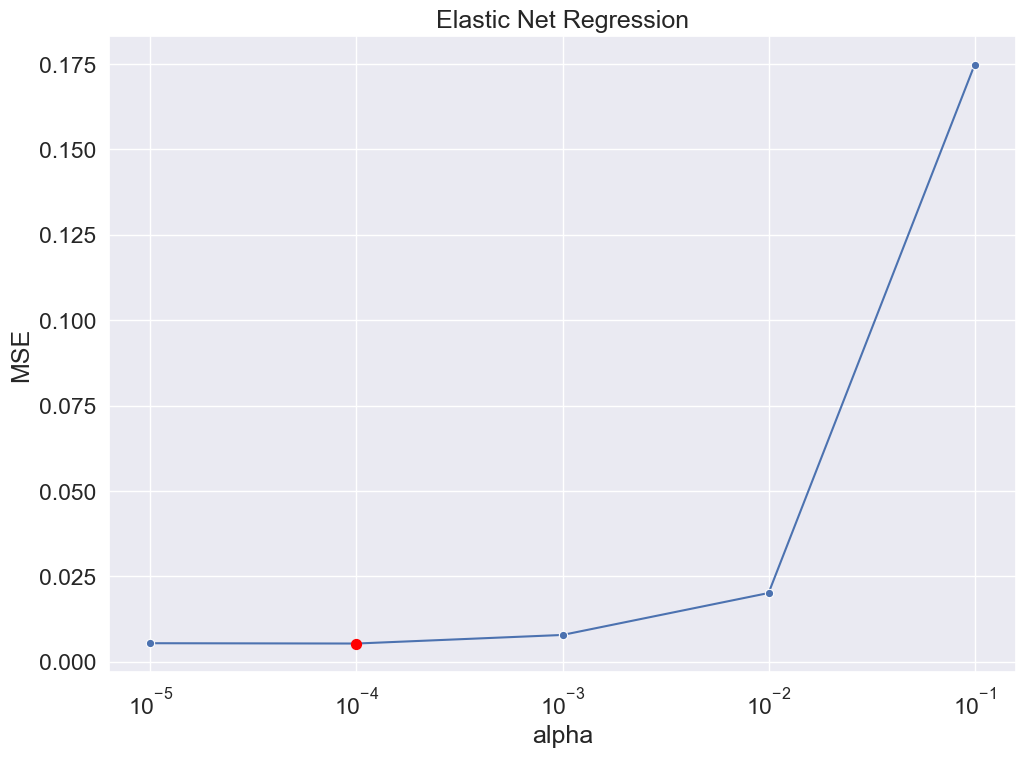

In [119]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(font_scale=1.5)

history_elastic = np.array(history_elastic)
history_elastic = history_elastic[history_elastic[:,0].argsort()]

ax = sns.lineplot(x=history_elastic[:,0], y=history_elastic[:,1], marker='o')
ax.set(xscale="log")
ax.set(xlabel='alpha', ylabel='MSE')
ax.set_title('Elastic Net Regression')
ax.scatter(elastic_best_a, elastic_best_mse, color='red', s=50, marker='o', zorder=3)

plt.show()